In [2]:
import pandas as pd
from typing import List, Union, Dict
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
import pickle as pkl

In [3]:
def get_feature_activation_scores_for_agent(feature: Union[str, int], agent_log_file: str) -> Dict[str, np.ndarray]:
    """
    Parses the agent log file and returns a list of the number of tokens in which the feature is active for the given agent.
    Note: The file contains logs from multiple runs on the same agent, hence the activations of the feature will be return for all runs.
    """
    with open(agent_log_file, 'rb') as f:
        logs = pkl.load(f)
    # log file is a list of dictionaries, each dictionary contains the log for one run and exeriment
    # scores[experiment_id][run_id] = [feature activations for experiment_id and run_id]
    scores = defaultdict(lambda: defaultdict(dict))
    for log in logs:
        experiment_id, run_id = log['experiment_id'], log['run_id']
        if log['feature']['label'] == feature:
            scores[experiment_id][run_id] = log['feature']['activations']
    for experiment_id in scores.keys():
        num_runs = len(scores[experiment_id])
        assert num_runs == max(scores[experiment_id].keys()) + 1, f"Experiment {experiment_id} has missing runs."
        scores[experiment_id] = np.array([scores[experiment_id][run_id] for run_id in range(num_runs)])
    return scores

def get_cooperation_rates(results_csv_file: str, agents: tuple=None) -> List[float]:
    """
    Parses the results CSV file and returns the cooperation rate
    for the given agent across multiple runs.

    columns: Round, A_0 Move, A_0 Payoff, A_0 Cumulative, A_0 Reason,
             A_1 Move, A_1 Payoff, A_1 Cumulative, A_1 Reason, ...
    """
    results = pd.read_csv(results_csv_file)
    if 'Experiment_id' not in results.columns:
        # add experiment id column if not present
        results['Experiment_id'] = 0
    if agents is None:
        agents = ['A_0', 'A_1']
    # parse the CSV to extract cooperation rates per run
    cooperation_rates = [{} for experiment_id in results['Experiment_id'].unique()]
    for experiment_id in results['Experiment_id'].unique():
        experiment_results = results[results['Experiment_id'] == experiment_id]
        # calculate cooperation rate for each agent
        for agent in agents:
            cooperation_rates[experiment_id][agent] = np.array((experiment_results[f'{agent} Move'] == 'Stay Silent'), dtype=int)
            cooperation_rates[experiment_id][agent] = cooperation_rates[experiment_id][agent].cumsum()
            for i, coop_value in enumerate(cooperation_rates[experiment_id][agent]):
                cooperation_rates[experiment_id][agent][i] = coop_value / (i + 1)  # calculate cooperation rate 
    return cooperation_rates

In [13]:
def generate_synthetic_agent_log(file_path: str, num_experiments: int = 2, runs_per_experiment: int = 5, feature_labels = ["deception", "honesty"]):
    """
    Generates a synthetic agent log file with fake feature activations across multiple experiments and runs.
    The file will be compatible with `get_feature_activation_scores_for_agent`.
    """
    logs = []

    for experiment_id in range(num_experiments):
        for run_id in range(runs_per_experiment):
            for feature in feature_labels:
                activations = np.random.uniform(0, 1) 
                log_entry = {
                    "experiment_id": f"exp_{experiment_id}",
                    "run_id": run_id,
                    "feature": {
                        "label": feature,
                        "activations": activations
                    }
                }
                logs.append(log_entry)

    with open(file_path, 'wb') as f:
        pkl.dump(logs, f)
    print(f"Synthetic agent log saved to {file_path}")
    return logs

In [25]:
def bootstrap_confidence_interval(data, num_samples=10000, confidence_level=0.95, random_seed=None):
    """
    Computes the confidence interval for the mean of the data using bootstrap resampling.
    """
    if random_seed is not None:
        np.random.seed(random_seed)

    data = np.array(data)
    n = len(data)
    boot_means = [np.mean(np.random.choice(data, size=n, replace=True)) for _ in range(num_samples)]

    alpha = 1 - confidence_level
    lower = np.percentile(boot_means, 100 * (alpha / 2))
    upper = np.percentile(boot_means, 100 * (1 - alpha / 2))
    return lower, upper


def plot_statistic(statistic_name: str,
                   data: Union[list[list[float]], np.ndarray],
                   use_bootstrap: bool = True,
                   num_bootstrap_samples: int = 10000,
                   confidence_level: float = 0.95,
                   save_path: str = None,
                   fmt : str = '-o'):
    """
    Plots the mean ± error for each index across multiple runs.

    Parameters:
    - statistic_name: Name for plot title.
    - data: 2D list (shape: [num_runs][num_features_or_rounds]) or numpy array.
    - use_bootstrap: Whether to use bootstrap CI instead of standard deviation.
    - save_path: Optional file path to save the plot.
    """

    data = np.array(data)  # Shape: (num_runs, num_features_or_rounds)
    num_points = data.shape[1]

    means = np.mean(data, axis=0) # Shape: (num_features_or_rounds,)
    if use_bootstrap:
        ci_lowers, ci_uppers = [], []
        for i in range(num_points):
            # Calculate bootstrap confidence interval for each feature/round
            lower, upper = bootstrap_confidence_interval(data[:, i],
                                                         num_samples=num_bootstrap_samples,
                                                         confidence_level=confidence_level)
            ci_lowers.append(means[i] - lower)
            ci_uppers.append(upper - means[i])
        yerr = [ci_lowers, ci_uppers]
    else:
        stds = np.std(data, axis=0, ddof=1)
        yerr = [stds, stds]

    x = np.arange(num_points)

    fig, ax = plt.subplots(figsize=(10, 5))
    ax.errorbar(x, means, yerr=yerr, fmt=fmt, capsize=5, color='blue', ecolor='red', elinewidth=1.5)

    ax.set_title(f"{statistic_name} (Mean ± {'95% CI' if use_bootstrap else 'Std'})")
    ax.set_xlabel("Feature / Round Index")
    ax.set_ylabel("Value")
    ax.set_xticks(x)

    plt.grid(True, linestyle='--', alpha=0.6)

    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
    else:
        plt.show()

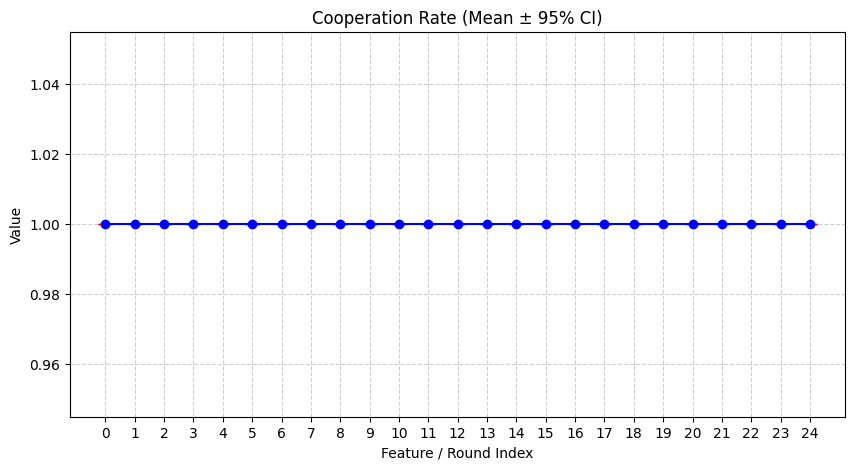

In [26]:
plot_statistic(statistic_name="Cooperation Rate",
                   data=np.array(get_cooperation_rates("./results/results_prompt_50_20250309-185047.csv")[0]['A_0'][:25]).reshape(1, -1),
                   use_bootstrap=True,
                   save_path="cooperation_rate.png")

Synthetic agent log saved to test_agent_log.pkl
exp_0: shape = (10,)
[0.71528911 0.68711326 0.730859   0.93365538 0.75052976 0.04116232
 0.62357468 0.92510355 0.01802276 0.33642544]
exp_1: shape = (10,)
[0.04369267 0.17268815 0.25606496 0.34680426 0.24998029 0.14850883
 0.44271566 0.12383483 0.19367678 0.15016219]


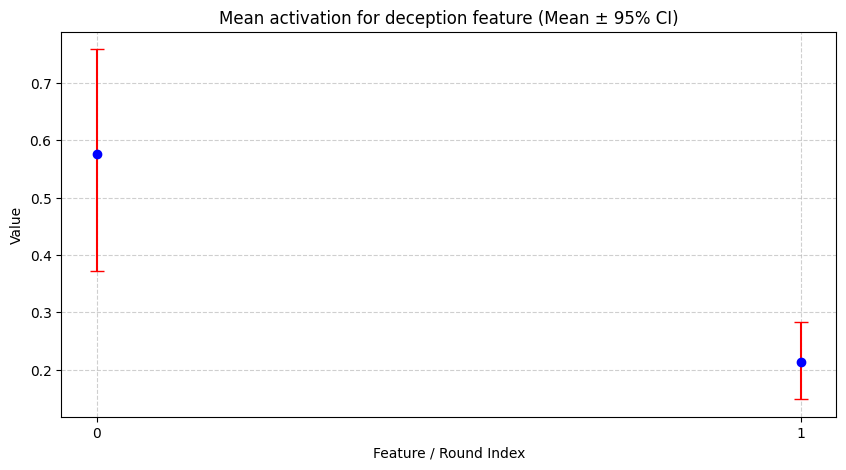

In [27]:
logs = generate_synthetic_agent_log("test_agent_log.pkl", num_experiments=
                             2, runs_per_experiment=10, feature_labels=["deception", "honesty"])
scores = get_feature_activation_scores_for_agent("deception", "test_agent_log.pkl")

for exp_id, data in scores.items():
    print(f"{exp_id}: shape = {data.shape}")
    print(data)

plot_statistic(statistic_name="Mean activation for deception feature",
                   data=np.array([scores[exp] for exp in scores.keys()]).T,
                   use_bootstrap=True,
                   save_path="mean_activation_deception_feature.png",
                   fmt='o')

## Statistical tests for the difference in means

In [28]:
def test_significance_between_agents(agent1_scores: Union[list, np.ndarray],
                                     agent2_scores: Union[list, np.ndarray],
                                     alpha: float = 0.05,
                                     use_bootstrap: bool = True,
                                     num_bootstrap_samples: int = 10000,
                                     confidence_level: float = 0.95,
                                     random_seed: int = None):
    """
    Tests whether the difference in mean cooperation rate between two agents is statistically significant,
    using bootstrap by default, and reports effect size (Cohen's d).

    Parameters:
    - agent1_scores: List or array of cooperation rates for agent 1.
    - agent2_scores: List or array of cooperation rates for agent 2.
    - alpha: Significance level (default = 0.05)
    - use_bootstrap: Whether to use bootstrap test instead of Welch’s t-test (default = True)
    - num_bootstrap_samples: Number of bootstrap resamples
    - confidence_level: Confidence level for bootstrap
    - random_seed: Random seed for reproducibility
    """

    agent1_scores = np.array(agent1_scores)
    agent2_scores = np.array(agent2_scores)

    mean1 = np.mean(agent1_scores)
    mean2 = np.mean(agent2_scores)
    diff_observed = mean1 - mean2

    # Calculate pooled standard deviation for effect size (Cohen's d)
    pooled_std = np.sqrt(((np.std(agent1_scores, ddof=1) ** 2 + np.std(agent2_scores, ddof=1) ** 2) / 2))
    cohen_d = diff_observed / pooled_std if pooled_std > 0 else float("inf")

    print(f"Agent 1 mean: {mean1:.4f}")
    print(f"Agent 2 mean: {mean2:.4f}")
    print(f"Observed difference: {diff_observed:.4f}")
    print(f"Cohen's d (effect size): {cohen_d:.4f}")

    if use_bootstrap:
        if random_seed is not None:
            np.random.seed(random_seed)

        combined = np.concatenate([agent1_scores, agent2_scores])
        n1 = len(agent1_scores)
        observed_diff = mean1 - mean2

        diffs = []
        for _ in range(num_bootstrap_samples):
            permuted = np.random.permutation(combined)
            new1 = permuted[:n1]
            new2 = permuted[n1:]
            diffs.append(np.mean(new1) - np.mean(new2))

        diffs = np.array(diffs)
        p_val = np.mean(np.abs(diffs) >= np.abs(observed_diff))
        print(f"Bootstrap p-value: {p_val:.4f} (samples = {num_bootstrap_samples})")

        # Confidence interval for difference in means
        lower = np.percentile(diffs, 100 * (1 - confidence_level) / 2)
        upper = np.percentile(diffs, 100 * (1 + confidence_level) / 2)
        print(f"{int(confidence_level * 100)}% CI for difference in means: [{lower:.4f}, {upper:.4f}]")
    else:
        from scipy.stats import ttest_ind
        t_stat, p_val = ttest_ind(agent1_scores, agent2_scores, equal_var=False)
        print(f"Welch’s t-test p-value: {p_val:.4f}")

    if p_val < alpha:
        print(f"✅ Statistically significant difference at α = {alpha}")
    else:
        print(f"❌ No statistically significant difference at α = {alpha}")
test_significance_between_agents(agent1_scores=scores["exp_0"],
                                     agent2_scores=scores["exp_1"],
                                     alpha=0.05,
                                     use_bootstrap=True,
                                     num_bootstrap_samples=10000,
                                     confidence_level=0.95,
                                     random_seed=42)

Agent 1 mean: 0.5762
Agent 2 mean: 0.2128
Observed difference: 0.3634
Cohen's d (effect size): 1.4608
Bootstrap p-value: 0.0048 (samples = 10000)
95% CI for difference in means: [-0.2657, 0.2621]
✅ Statistically significant difference at α = 0.05
